In [12]:
import pandas as pd
import tweepy as tw
import re
!pip3 install pickle5
import pickle5 as pickle
with open('twitter_privacy1000.pkl', "rb") as fh:
  tweets = pickle.load(fh)
# tweets = pd.read_pickle('twitter_privacy1000.pkl')
print(len(tweets))
tweets['text_processed'] = tweets['text'].map(lambda x: re.sub('[,\.!?@]', '', x))

tweets['text_processed'] = tweets['text_processed'].map(lambda x: x.lower())

print(tweets['text_processed'].head())

1000
0    left: samsung smarttv privacy policy warning u...
1    they can match my harris teeter purchases to m...
2    bombshell report by rolling stone: wray lied t...
3    how can a corporate privacy policy override th...
4    new eu laundering rules could be unworkable an...
Name: text_processed, dtype: object


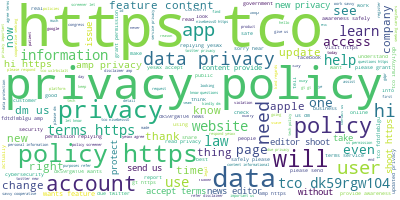

In [18]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(tweets['text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [19]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['tco', 'dk59rgw104', 'dm', 'hi', 'https'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = tweets.text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['left', 'samsung', 'smarttv', 'privacy', 'policy', 'warning', 'users', 'discuss', 'personal', 'info', 'front', 'tv', 'right', 'http', 'osywjykv']


In [35]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]


In [21]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.035*"privacy" + 0.027*"policy" + 0.010*"amp" + 0.008*"information" + '
  '0.007*"us" + 0.006*"important" + 0.006*"legal" + 0.006*"girls" + '
  '0.005*"free" + 0.005*"one"'),
 (1,
  '0.040*"privacy" + 0.038*"policy" + 0.010*"amp" + 0.009*"us" + '
  '0.008*"account" + 0.007*"new" + 0.007*"gt" + 0.006*"please" + 0.005*"data" '
  '+ 0.005*"disclaimer"'),
 (2,
  '0.027*"policy" + 0.023*"privacy" + 0.008*"would" + 0.007*"ecommerce" + '
  '0.006*"create" + 0.005*"us" + 0.005*"privacypolicy" + 0.005*"amp" + '
  '0.004*"one" + 0.003*"team"'),
 (3,
  '0.037*"privacy" + 0.037*"policy" + 0.016*"data" + 0.011*"amp" + 0.009*"us" '
  '+ 0.007*"personal" + 0.005*"please" + 0.005*"read" + 0.004*"information" + '
  '0.004*"users"'),
 (4,
  '0.047*"privacy" + 0.038*"policy" + 0.011*"data" + 0.009*"please" + '
  '0.009*"us" + 0.006*"contact" + 0.006*"like" + 0.005*"amp" + 0.005*"learn" + '
  '0.004*"details"'),
 (5,
  '0.027*"privacy" + 0.024*"policy" + 0.008*"data" + 0.007*"amp" + '
  '0.006*"i

In [47]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9437,"privacy, policy, amp, information, us, important, legal, girls, free, one","[left, samsung, smarttv, privacy, policy, warning, users, discuss, personal, info, front, tv, ri..."
1,1,1.0,0.9571,"privacy, policy, amp, us, account, new, gt, please, data, disclaimer","[match, harris, teeter, purchases, twitter, account, gave, companies, email, address, phone, num..."
2,2,4.0,0.9700,"privacy, policy, data, please, us, contact, like, amp, learn, details","[bombshell, report, rolling, stone, wray, lied, congress, despite, wray, denial, oath, fbi, extr..."
3,3,4.0,0.9640,"privacy, policy, data, please, us, contact, like, amp, learn, details","[corporate, privacy, policy, override, constitution, kenya, corporate, policy, supposed, align, ..."
4,4,6.0,0.9571,"privacy, policy, new, account, say, terms, others, eu, get, free","[new, eu, laundering, rules, could, unworkable, destructive, industry, worry, others, say, crypt..."
5,5,5.0,0.9625,"privacy, policy, data, amp, information, change, use, twitter, protonvpn, security","[third, time, ftc, forced, company, destroy, algorithms, built, data, gathered, deceptively, sig..."
6,6,4.0,0.9640,"privacy, policy, data, please, us, contact, like, amp, learn, details","[corporate, privacy, policy, override, constitution, kenya, corporate, policy, supposed, align, ..."
7,7,0.0,0.9710,"privacy, policy, amp, information, us, important, legal, girls, free, one","[monsoonuk, charliesnovella, dear, monsoonuk, shopping, daughters, clothes, stores, aware, polic..."
8,8,3.0,0.9640,"privacy, policy, data, amp, us, personal, please, read, information, users","[giveaway, win, eurs, largest, euro, backed, stablecoin, follow, wirexapp, stasisnet, tag, frien..."
9,9,1.0,0.9550,"privacy, policy, amp, us, account, new, gt, please, data, disclaimer","[hackers, increasingly, target, reputations, reviews, sites, experts, say, found, via, cronycle,..."


In [37]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9710,"privacy, policy, amp, information, us, important, legal, girls, free, one","[dear, monsoonuk, shopping, daughters, clothes, stores, aware, policy, allow, men, woman, girls,..."
1,1.0,0.9804,"privacy, policy, amp, us, account, new, gt, please, data, disclaimer","[mstratford, johnbking, free_to_prosper, unidir, wgeid, intlcrimcourt, courpenaleint, debtcrisis..."
2,2.0,0.9700,"policy, privacy, would, ecommerce, create, us, privacypolicy, amp, one, team","[jan_forney, sfchronicle, rnoccupational, hospital, case, managerkong, term, ufhealth, employee,..."
3,3.0,0.9735,"privacy, policy, data, amp, us, personal, please, read, information, users","[meet, avika, amp, selena, two, stanford, students, amp, winning, team, california, tech, policy..."
4,4.0,0.9763,"privacy, policy, data, please, us, contact, like, amp, learn, details","[hmkhan, officialdgispr, zartajgulwazir, imranriazkhan, imrankhanpti, insafpk, muradsaeedpti, fa..."
5,5.0,0.9743,"privacy, policy, data, amp, information, change, use, twitter, protonvpn, security","[diggi, arvindkejriwal, android, easy, hacked, iphone, way, privacy, friendly, bec, iphone, want..."
6,6.0,0.9735,"privacy, policy, new, account, say, terms, others, eu, get, free","[valueaddedrs, annetterobidoux, askebay, terms, service, link, privacy, policy, link, opens, new..."
7,7.0,0.9842,"privacy, policy, data, account, us, please, tech, new, competition, rights","[realdoctort, thinkingsapien, gumbeauxmike, mark_i, angryfleas, shadowdroid, john_iwas_, admone,..."
8,8.0,0.9743,"policy, privacy, data, help, please, us, work, terms, social, account","[elonmusk, first, safe, social, network, made, india, world, hftfj, sfye, user, get, verified, i..."
9,9.0,0.9727,"privacy, policy, terms, please, dk, rgw, permission, amp, yeswx, content","[thatkevinsmith, secretnetwork, legendaonft, curionft, people, wont, really, understand, possibi..."


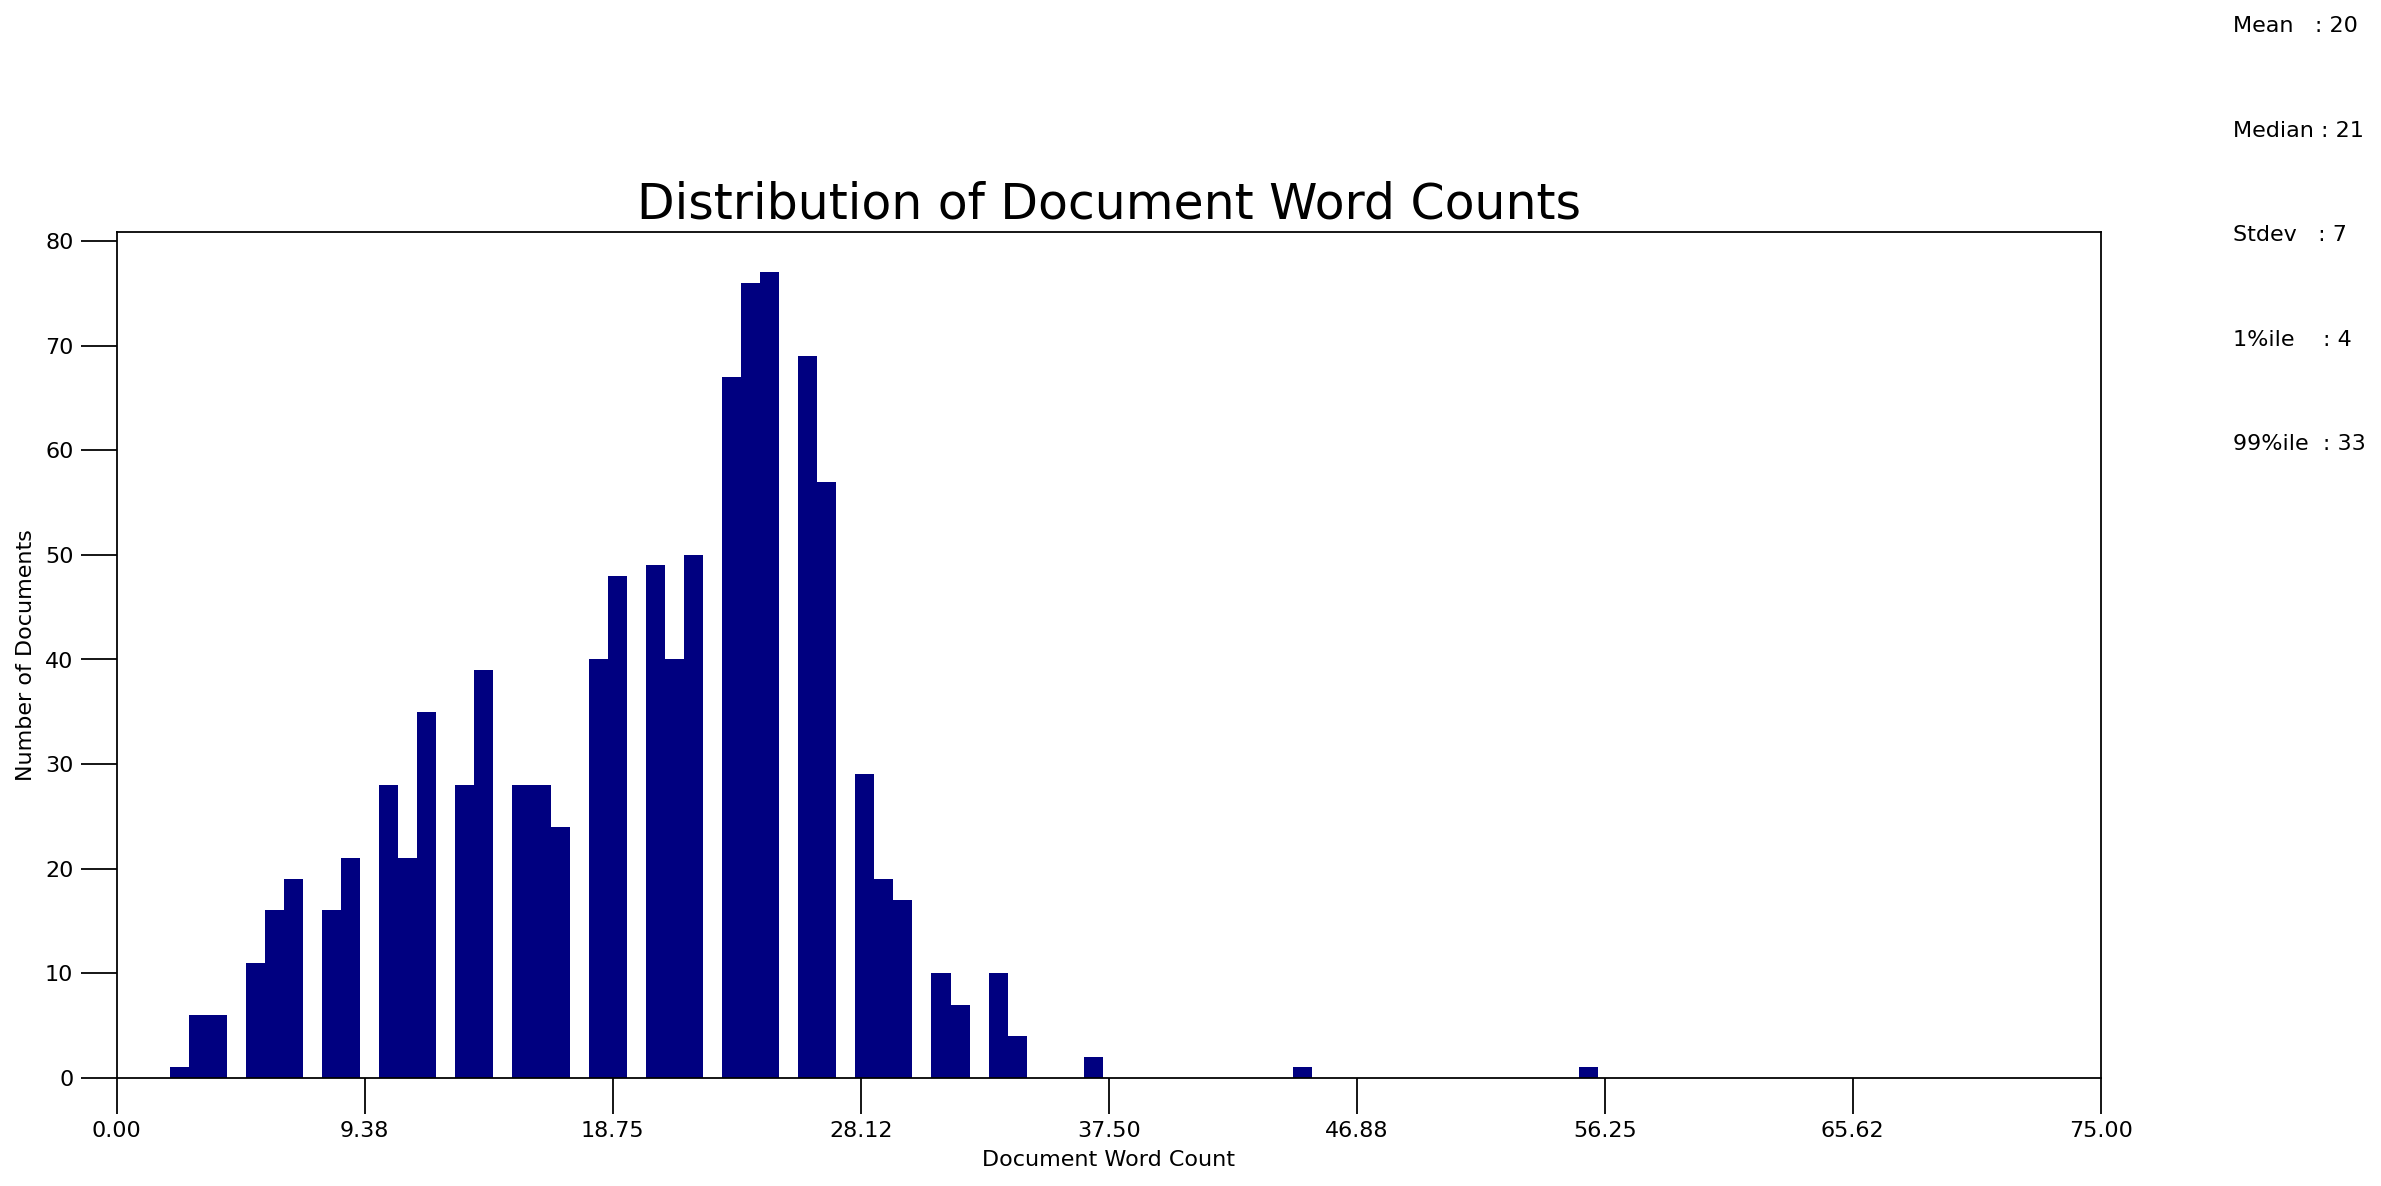

In [45]:
import matplotlib.pyplot as plt
import numpy as np

doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 75, color='navy')
plt.text(80, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(80,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(80,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(80,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(80,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 75), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,75,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

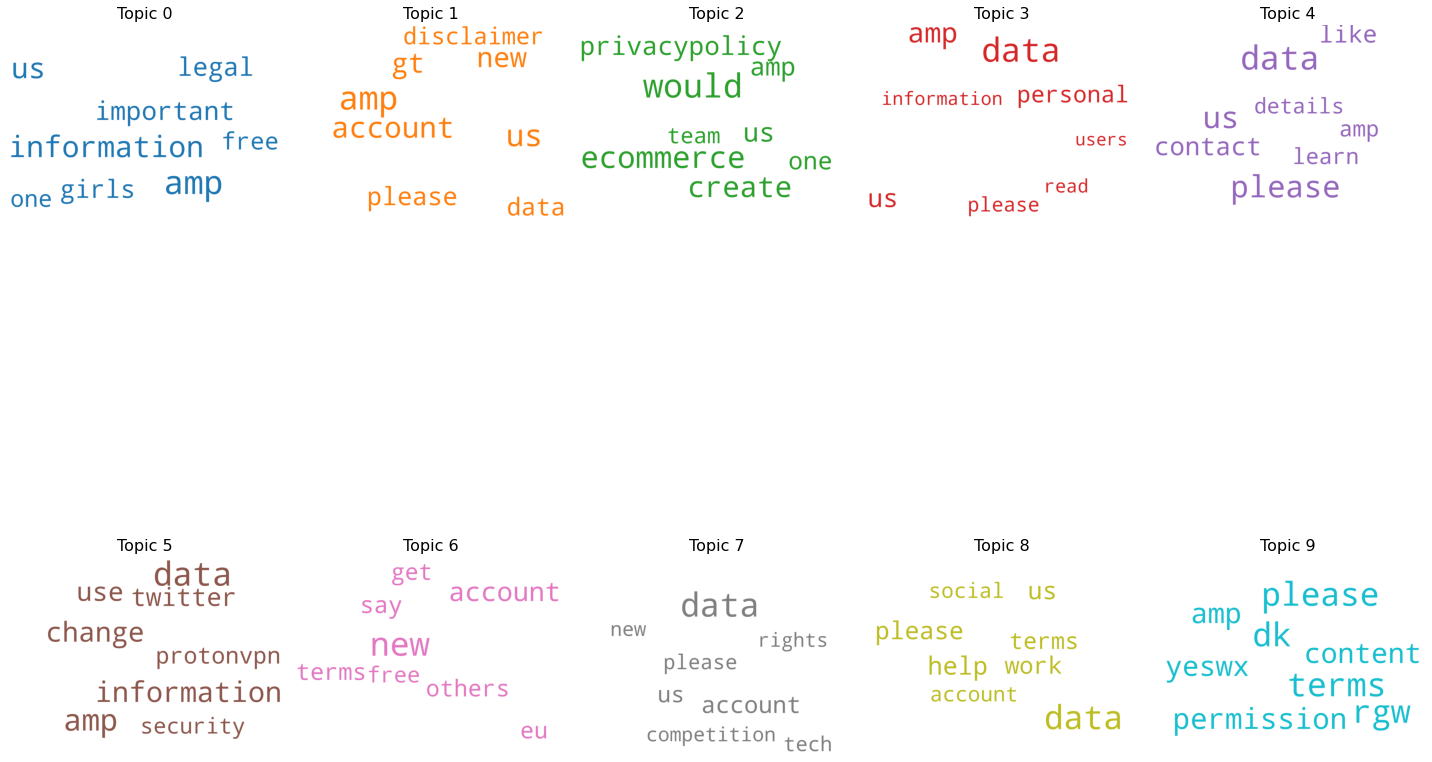

In [52]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    # print(topic_words)
    topic_words.pop('privacy')
    topic_words.pop('policy')
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

LDA

In [ ]:
# !pip install pyLDAvis==2.1.2
# import pyLDAvis.gensim
# import pickle 
# import pyLDAvis
# # Visualize the topics
# pyLDAvis.enable_notebook()
# LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # # this is a bit time consuming - make the if statement True
# # # if you want to execute visualization prep yourself
# # if 1 == 1:
# LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
# with open(LDAvis_data_filepath, 'wb') as f:
#     pickle.dump(LDAvis_prepared, f)
# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
# LDAvis_prepared